In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
# nicer looking default plots
plt.style.use('bmh')
from time import time

# Example 1 - Forward Euler


Consider first the ODE
$$ \dot{x} = x $$
This has analytic solution
$$ x(t) = x_0\mathrm{e}^t $$
where $$x_0 = x(t=0)$$

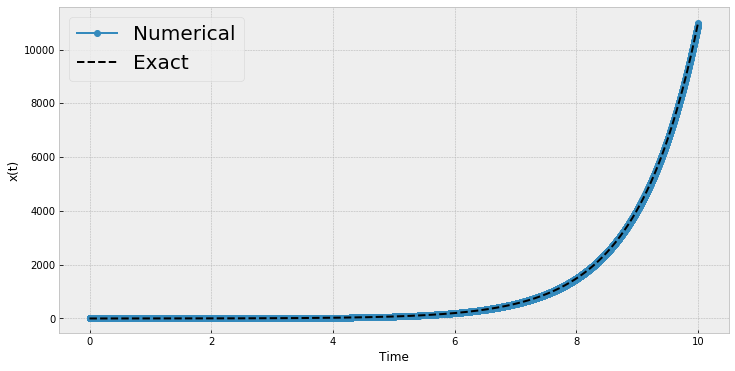

In [31]:
def f(x, t):
    return x

# Initial conditions
x    = 1/2
t    = 0
Tmax = 10
# Timestep
h    = 0.001

# Keep list of trajectories and times for plotting
Xs = [x]
Ts = [t]
while t < Tmax:
    # At each step, use derivative at that position
    x = x + h*f(x, t)
    # Increment time
    t += h
    # Store time and position
    Ts.append(t)
    Xs.append(x)

fig = plt.figure(figsize = (12,6))

# Plot numerical solution
plt.plot(Ts, Xs, marker = 'o', label = 'Numerical')

# Plot analytic solution
x0 = Xs[0]
# Define an array of times at high resolution
ts = np.linspace(Ts[0], Ts[-1], 1000)
plt.plot(ts, x0*np.exp(ts), '--', c = 'k', label = 'Exact')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.legend(loc = 'upper left', fontsize = 20)

# Example 2 - Better coding practice
## and also comparison between Forward Euler and 4th-order Runge-Kutta

* Implement integrator to take f as an argument
* Use consistent call signature for f
* Make a function that will take f and an integrator, and step forward in time until Tmax

* Also: Try modifying the timestep, and note how much faster the 4th-order Runge-Kutta converges compared to the 1st-order Euler method

In [4]:
#####################
#### Integrators ####
#####################

# The forward Euler method
def euler(x, t, h, f):
    # x is coordinates (as a vector)
    # h is timestep
    # f(x) is a function that returns the derivative
    # "Slopes"
    k1  = f(x,           t)
    # Update time and position
    x_  = x + h*k1
    return x_

# Heun's Method
def rk2(x, t, h, f):
    # x is coordinates (as a vector)
    # h is timestep
    # f(x) is a function that returns the derivative
    # "Slopes"
    k1  = f(x,          t)
    k2  = f(x + k1*h,   t + h)
    # Update time and position
    x_ = x + h*(k1 + k2)/2
    return x_

# Kutta's method
def rk3(x, t, h, f):
    # x is coordinates (as a vector)
    # h is timestep
    # f(x) is a function that returns the derivative
    # "Slopes"
    k1  = f(x,                 t)
    k2  = f(x + k1*h/2,        t + h/2)
    k3  = f(x - k1*h + 2*k2*h, t + h)
    # Update time and position
    x_  = x + h*(k1 + 4*k2 + k3)/6
    return x_

# 4th-order Runge-Kutta
def rk4(x, t, h, f):
    # x is coordinates (as a vector)
    # h is timestep
    # f(x) is a function that returns the derivative
    # "Slopes"
    k1  = f(x,          t)
    k2  = f(x + k1*h/2, t + h/2)
    k3  = f(x + k2*h/2, t + h/2)
    k4  = f(x + k3*h,   t + h)
    # Update time and position
    x_  = x + h*(k1 + 2*k2 + 2*k3 + k4)/6
    return x_

In [32]:
###########################
#### Utility functions ####
###########################

def trajectory(X0, T0, Tmax, h, f, integrator):
    # Number of timesteps
    Nt   = int((Tmax) / h)
    # Add 2 for initial position and fractional step at end
    # X0.size lets X hold Nt+2 arrays of the same size as X0
    X0   = np.array(X0)
    X    = np.zeros((Nt+2, X0.size))
    T    = np.zeros(Nt+2)
    # Initialise
    X[0,:] = X0
    T[0]   = T0
    # Loop over timesteps
    t = T0
    for i in range(Nt+1):
        # Make sure the last step stops exactly at Tmax
        h  = min(h, Tmax - t)
        # Calculate next position
        X[i+1,:] = integrator(X[i,:], t, h, f)
        T[i+1] = T[i] + h
        # Increment time
        t += h
    return X, T

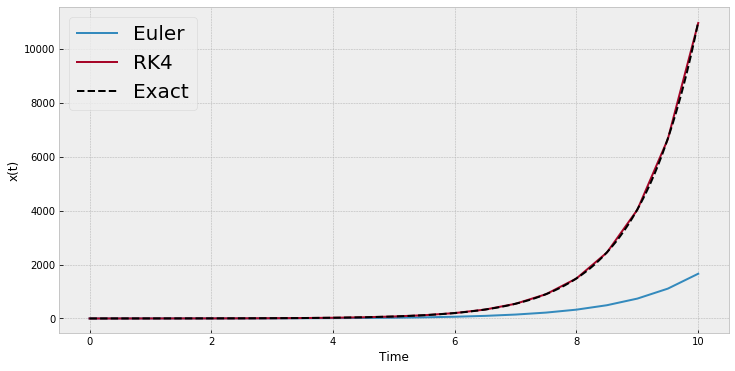

In [36]:
def f(x, t):
    return x

# Initial conditions
x0   = 1/2
t0   = 0
Tmax = 10
# Timestep
h    = 0.5

# The integrators and the function trajectory are implemented
# at the top of the notebook
X_euler, Ts = trajectory(x0, t0, Tmax, h, f, euler)
X_rk4, Ts   = trajectory(x0, t0, Tmax, h, f, rk4)

# Make a figure
fig = plt.figure(figsize = (12,6))

# Plot numerical solutions
plt.plot(Ts, X_euler, label = 'Euler')
plt.plot(Ts, X_rk4, label = 'RK4')

# Plot analytic solution
# Define an array of times at high resolution
ts = np.linspace(Ts[0], Ts[-1], 1000)
x0 = Xs[0]
plt.plot(ts, x0*np.exp(ts), '--', c = 'k', label = 'Exact')

# Labels
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.legend(loc = 'upper left', fontsize = 20)

# Example 3 - Error as function of timestep

To look at error as a function of timestep:
* Calculate trajectory for many different timesteps
* Calculate error as $x(t_N) - x_N$, where $N$ is the total number of timesteps and $x(t_N)$ is the exact solution at $t_N$.
* Plot on log-log scale, and add straight lines proportiona to $h$ and $h^4$ to compare slope
* The reason the error doesn't get smaller than about $10^{-12}$ in this case is due to limited precision in floating point numbers, and the large number of steps for the shorter timesteps

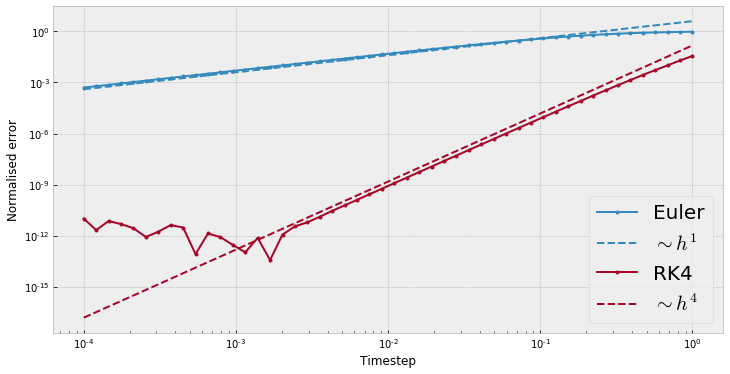

In [35]:
def f(x, t):
    return x

# Initial conditions
x0   = 1/2
t0   = 0
Tmax = 10

# Define Nh logarithmically spaced timesteps from 0.0001 to 1
Nh = 50
timesteps = np.logspace(-4, 0, Nh)

# For each of those timesteps, calculate the endpoint of the trajectory
Xe_euler = np.zeros(Nh)
Xe_rk4   = np.zeros(Nh)
for i, h in enumerate(timesteps):
    Xs, Ts = trajectory(x0, t0, Tmax, h, f, euler )
    Xe_euler[i] = Xs[-1]
    Xs, Ts = trajectory(x0, t0, Tmax, h, f, rk4   )
    Xe_rk4[i]   = Xs[-1]

    
# Analytic solution
Xact = x0*np.exp(Tmax)
# Calculate error, normalised by exact solution
err_euler = np.abs(Xe_euler - Xact) / Xact
err_rk4   = np.abs(Xe_rk4   - Xact) / Xact

fig = plt.figure(figsize = (12,6))
# Plot error as function of timesteps
# And plot straight lines to show slope
l, = plt.plot(timesteps, err_euler, marker = '.', label = 'Euler')
plt.plot(timesteps, 4.0*timesteps**1, '--', c = l.get_color(), label = '$\sim h^1$')
l, = plt.plot(timesteps, err_rk4,   marker = '.', label = 'RK4')
plt.plot(timesteps, 0.15*timesteps**4, '--', c = l.get_color(), label = '$\sim h^4$')

plt.legend(loc = 'lower right', fontsize = 20)
plt.xlabel('Timestep')
plt.ylabel('Normalised error')

# Logscale
plt.xscale('log')
plt.yscale('log')

# Example 4 - Restricted three-body problem

This example is taken from _Solving Ordinary Differential Equations, vol I_ by Hairer, Nørsett and Wanner, beginning of Chapter II. You can download the book as a free pdf from Springer if you are on the NTNU network:

http://link.springer.com/book/10.1007%2F978-3-540-78862-1

The system is the gravitational three-body problem, for a system made up of the Earth, the Moon and a spacecraft, and with the simplification that the motion of the Earth and Moon are unaffected by the spacecraft (which seems reasonable). The equations are given in dimensionless form.

The equations are given as second order equations for the two components of the position vector:

$$ \ddot{y_1} = y_1 + 2\dot{y_2} - \mu' \frac{y_1 + \mu}{D_1} - \mu\frac{y_1 - \mu'}{D_2}$$
$$ \ddot{y_2} = y_2 + 2\dot{y_1} - \mu' \frac{y_2}{D_1} - \mu\frac{y_1}{D_2}$$
$$ D_1 = \left( (y_1 + \mu)^2 + y_2^2\right)^{3/2} $$
$$ D_1 = \left( (y_1 - \mu')^2 + y_2^2\right)^{3/2} $$
$$ \mu = 0.012277471 $$
$$ \mu' = 1 - \mu. $$

With the initial conditions
$$ y_1(0) = 0.994 $$
$$ \dot{y_1}(0) = 0 $$
$$ y_2(0) = 0 $$
$$ \dot{y_2}(0) = -2.00158520637908252240537862224, $$

these equations will exhibit a periodic solution with period

$$ T = 17.0652165601579625588917206249. $$

The point of the example is that the trajectory changes quickly close to the Moon, and less quickly elsewhere. However, since we must choose the timestep short enough to capture the dynamics close to the Moon, we  are forced to use an excessively short timestep for the rest of the orbit as well, unless we use a method with adaptive timestep.

Below, we first define the function `fa(x, t)` which implements the above equations, rewritten into a system of four first-order ODEs. We then integrate the trajectories using the 4th-order Runge-Kutta method, before moving on to variable timestep methods.

Number of steps:  68262
Simulation took  4.7098469734191895  seconds


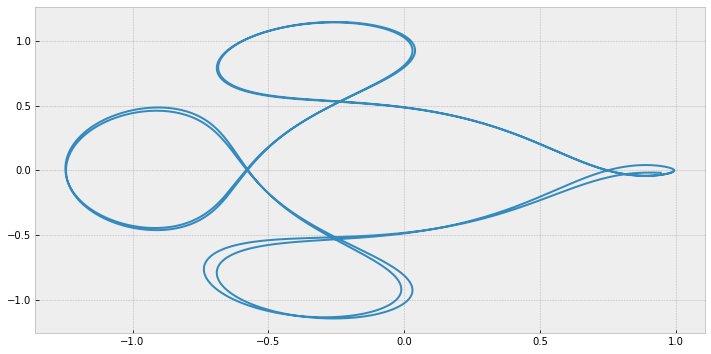

In [40]:
def fa(X, t):
    # Example taken from beginning of Chapter II in
    # Hairer, Nørsett, Wanner
    # Solving Ordinary Differential Equations, vol I
    # X[0] = y1
    # X[1] = y1dot
    # X[2] = y2
    # X[3] = y2dot
    # Constants
    mu  = 0.012277471
    mu_ = 1 - mu
    # Variable parameters
    D1 = ((X[0] + mu )**2 + X[2]**2)**(3/2)
    D2 = ((X[0] - mu_)**2 + X[2]**2)**(3/2)
    # Derivatives
    dX0 = X[1]
    dX1 = X[0] + 2*X[3] - mu_*(X[0] + mu)/D1 - mu*(X[0] - mu_)/D2
    dX2 = X[3]
    dX3 = X[2] - 2*X[1] - mu_*X[2]/D1        - mu*X[2]/D2
    return np.array([dX0, dX1, dX2, dX3])
    
    
t  = 0
T  = 17.06521656015796
X0 = np.array([
         0.994, # y1(0)
         0.0,   # y1'(0)
         0.0,   # y2(0)
        -2.001585106379082522405 # y2'(0)
    ])


# Intergrate for a duration equal to 2T.
# If the error after the first orbit is too large,
# the second orbit will be completely off.
# Try experimenting with the timestep.
h  = 5e-4

# Also, measure the time of the calculation
tic = time()
Xs, Ts = trajectory(X0, t, 2*T, h, fa, rk4)
toc = time()
print('Number of steps: ', len(Ts))
print('Simulation took ', toc - tic, ' seconds')

fig = plt.figure(figsize = (12, 6))
plt.plot(Xs[:,0], Xs[:,2])

# Example 5 - Variable timestep

Below is an example of a very straightforward implementation of a variable timestep code. It makes two estimates of the next position, compares the two, and assumes that the error is related to the difference. If the difference is small, the timestep is probably short enough, if the difference is large, we should reduce the timestep.

A more advanced implementation is shown further down.

In [16]:
#######################################
#### Variable stepsize integrators ####
#######################################

def rk43(x, t, h, f, atol = 1e-4, rtol = 1e-4):
    # Calculate 3rd and 4th order prediction
    x3 = rk3(x, t, h, f)
    x4 = rk4(x, t, h, f)
    # Error is related to difference between x3 and x4
    # Choosing here to use norm of difference divided by norm of x4
    # Other measures of error exists
    # rtol is relative tolerance
    # atol is absolute tolerance
    sc  = rtol*np.sum(np.sqrt(x4**2)) + atol
    err = np.sum(np.sqrt((x3 - x4)**2)) / sc
    if err < 1:
        # Step is accepted
        # Use 4th order as next position and update time
        x_ = x4
        t_ = t + h
        # Try increasing timestep a bit
        h_ = 1.5*h
    else:
        # Step is rejected
        # Do not update time and position
        x_ = x
        t_ = t
        # Try decreasing timestep a bit
        h_ = 0.5*h
    return x_, t_, h_


#############################################
#### Function for calculating trajectory ####
#############################################

def variable_step_trajectory(X0, T0, Tmax, h, f, integrator, tol = 1e-3):
    # In this case, number of steps is not known beforehand.
    # If we want to plot the trajectory, there are two simple options:
    # 1: Specify an output timestep, and store that often
    # 2: Store all steps in a list that grows 
    # We'll go for 2, since that allows us to visualise the steplengths,
    X = [X0]
    T = [0.0]
    t = 0
    rejected = 0
    while t < Tmax:
        # Make sure last step doesn't take us past Tmax
        h  = min(h, Tmax - t)
        # Integrator now returns not only x, but also h and t
        # Overwrite h, but store x_ and t_ in temporary variables
        x_, t_, h = integrator(X[-1], t, h, f, atol = tol, rtol = tol)
        # Only store x_ if step was accepted (in which case t_ > t)
        if t_ > t:
            X.append(x_)
            T.append(t_)
            t = t_
        else:
            rejected += 1
    # Now we must return t as well, since h is variable
    # Convert to array before returning
    return np.array(X), np.array(T), rejected

Number of steps:  993
Simulation took  0.24026894569396973  seconds
Number of rejected steps:  578


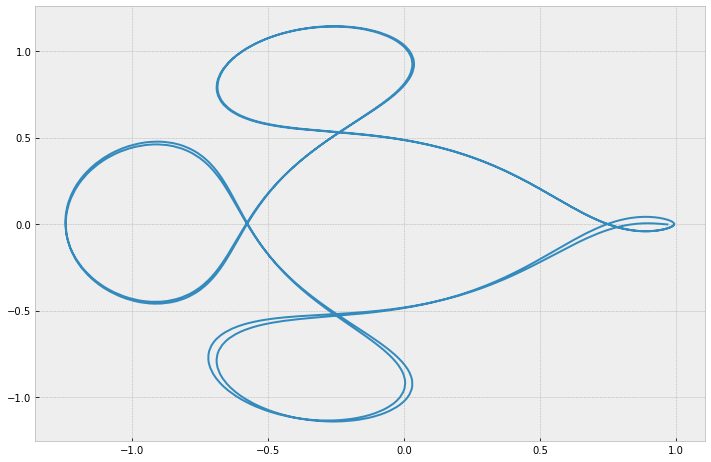

In [45]:
t  = 0
T  = 17.06521656015796
X0 = np.array([
         0.994, # y1(0)
         0.0,   # y1'(0)
         0.0,   # y2(0)a
        -2.001585106379082522405 # y2'(0)
    ])


# Starting timestep
h0 = 1e-3
# Again integrating two orbits. Compare number of steps to R-K 4 above.
tic = time()
Xs, Ts, R = variable_step_trajectory(X0, t, 2*T, h0, fa, rk43, tol = 2e-6)
toc = time()
print('Number of steps: ', len(Ts))
print('Simulation took ', toc - tic, ' seconds')
print('Number of rejected steps: ', R)

fig = plt.figure(figsize = (12, 8))
plt.plot(Xs[:,0], Xs[:,2])#, marker = '.')

Text(0.5,0,'Time')

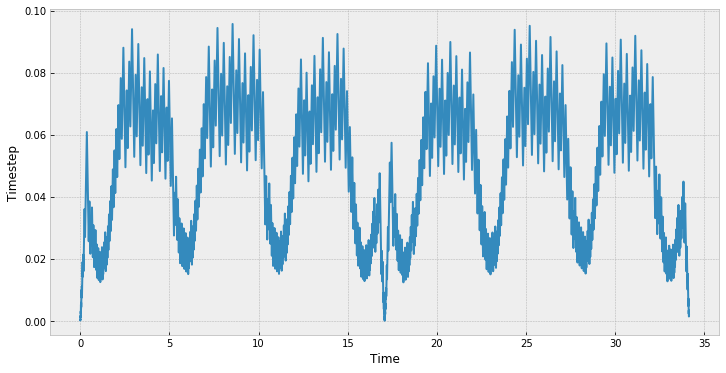

In [46]:
# Plot steplengths as function of time
hs = Ts[1:] - Ts[:-1]

fig = plt.figure(figsize = (12, 6))
plt.plot(Ts[1:], hs)
plt.ylabel('Timestep')
plt.xlabel('Time')

# Example 6 - Dormand and Prince 5(4)

This example includes an implementation of the Dormand-Prince method, which is a method that makes one 5th-order and one 4th-order prediction of the next step, using only 7 evaluations of $f(x,t)$, and uses the 5th-order prediction as the estimate of the next point.

Stepsize control is based on a recipe from _Solving Ordinary Differential Equations, vol I_ by Hairer, Nørsett and Wanner, page 167-168 (see link further up). It uses the error and the current timestep to calculate the optimal timestep, i.e., the timestep that would produce an error exactly matching the tolerance. It then sets the sets the timestep a little smaller than this. The result is a quite efficient method where fewer steps are rejected than the simpler approach above.

In [22]:
def dopri5(x, t, h, f, atol = 1e-6, rtol = 1e-6):
    # x and t are coordinates
    # h is timestep
    # f(t, x) is a function that returns the derivative
    
    # Nodes
    c1  =  0
    c2  =  1./5.
    c3  =  3./10.
    c4  =  4./5.
    c5  =  8./9.
    c6  =  1.
    c7  =  1.
    # Matrix elements
    a21 =  1./5.
    a31 =  3./40.
    a32 =  9./40.
    a41 =  44./45.
    a42 = -56./15.
    a43 =  32./9.
    a51 =  19372./6561.
    a52 = -25360./2187.
    a53 =  64448./6561.
    a54 = -212./729.
    a61 =  9017./3168.
    a62 = -355./33.
    a63 =  46732./5247.
    a64 =  49./176.
    a65 = -5103./18656.
    a71 =  35./384.
    a72 =  0.
    a73 =  500./1113.
    a74 =  125./192.
    a75 = -2187./6784.
    a76 =  11./84.
    # Fourth order weights
    b41 =  5179./57600.
    b42 =  0.
    b43 =  7571./16695.
    b44 =  393./640.
    b45 = -92097./339200.
    b46 =  187./2100.
    b47 =  1./40.
    # Fifth order weights
    b51 =  35./384.
    b52 =  0.
    b53 =  500./1113.
    b54 =  125./192.
    b55 = -2187./6784.
    b56 =  11./84.
    b57 =  0.
    
    # "Slopes"
    k1  = f( x,                                                                   t + c1*h )
    k2  = f( x + a21*h*k1,                                                        t + c2*h )
    k3  = f( x + a31*h*k1 + a32*h*k2,                                             t + c3*h )
    k4  = f( x + a41*h*k1 + a42*h*k2 + a43*h*k3,                                  t + c4*h )
    k5  = f( x + a51*h*k1 + a52*h*k2 + a53*h*k3 + a54*h*k4,                       t + c5*h )
    k6  = f( x + a61*h*k1 + a62*h*k2 + a63*h*k3 + a64*h*k4 + a65*h*k5,            t + c6*h )
    k7  = f( x + a71*h*k1 + a72*h*k2 + a73*h*k3 + a74*h*k4 + a75*h*k5 + a76*h*k6, t + c7*h )

    # Calculate fourth and fifth order prediction of new point
    x4  = x + h*(k1*b41 + k2*b42 + k3*b43 + k4*b44 + k5*b45 + k6*b46 + k7*b47)
    x5  = x + h*(k1*b51 + k2*b52 + k3*b53 + k4*b54 + k5*b55 + k6*b56 + k7*b57)
    
    # Implementing error checking and variable stepsize roughly as in
    # Hairer, Nørsett and Wanner:
    # Solving ordinary differential equations I -- Nonstiff problems
    # pages 167 and 168 in the 2008 printing

    # these are 4th and 5th order methods, q = min(4, 5)
    q   = 4.
    sc  = np.maximum(np.abs(x4), np.abs(x5)) * rtol + atol
    err = np.amax(np.sqrt(((x4 - x5) / sc)**2))
    # parameters limiting change in timestep
    fac    = 0.8
    maxfac = 2.5
    # Calculating optimal h
    # If err happens to be 0 (can happen, depending on problem)
    # then hopt = Infinity. Set some lower limit.
    if err < 1e-21:
        err = 1e-21
    h_opt = h * (1./err) ** (1./(q+1.))
    if err <= 1.0:
        # Step is accepted:
        # Use fifth order result as next position
        x_ = x5
        t_ = t + h
        # Increase steplength somewhat less than predicted, to
        # make it likely the next step is accepted
        h_ = min(maxfac * h, fac * h_opt)
    else:
        # Step is rejected:
        # Position and time is not updated
        x_ = x
        t_ = t
        # Decrease steplength
        h_   = fac * h_opt
    return x_, t_, h_

Number of steps:  275
Simulation took  0.09623384475708008  seconds
Number of rejected steps:  26


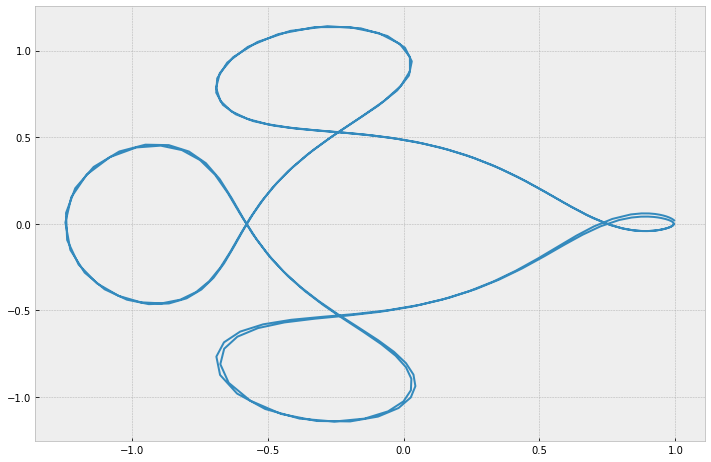

In [49]:
t  = 0
T  = 17.06521656015796
X0 = np.array([
         0.994, # y1(0)
         0.0,   # y1'(0)
         0.0,   # y2(0)a
        -2.001585106379082522405 # y2'(0)
    ])

# Starting timestep
h0 = 1e-3
# Again integrating two orbits. Compare number of steps to R-K 4 above.
tic = time()
Xs, Ts, R = variable_step_trajectory(X0, t, 2*T, h0, fa, dopri5, tol = 2e-6)
toc = time()
print('Number of steps: ', len(Ts))
print('Simulation took ', toc - tic, ' seconds')
print('Number of rejected steps: ', R)


fig = plt.figure(figsize = (12, 8))
# Include markers a each point to illustrate stepsize
plt.plot(Xs[:,0], Xs[:,2])#, marker = '.')

Text(0.5,0,'Time')

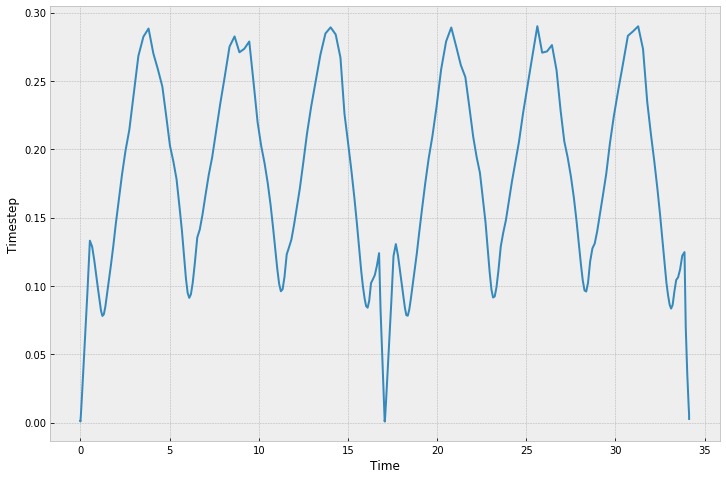

In [50]:
# Plot steplengths as function of time
hs = Ts[1:] - Ts[:-1]

fig = plt.figure(figsize = (12, 8))
plt.plot(Ts[1:], hs)
plt.ylabel('Timestep')
plt.xlabel('Time')

# Example 7 - Stiff equations

The idea here is to compare two equations that predict almost exactly equal trajectories, but with very different numerical properties.

Consider first an equation that discribes a trajectory moving towards $x=0$, with speed proportional to the distance:

$$\dot{x} = v(x),$$
where
$$v(x) = -x.$$

Consider next an equation that discribes a trajectory that experiences acceleration if the speed deviates from $v(x)$, proportional to the difference:

$$\ddot{x} = \alpha (v(x) - \dot{x}) $$

again with
$$v(x) = -x.$$

The physical interpretation can be in the first case a particle that moves with the velocity given by $v(x)$, and in the second case of a particle that experiences a force, which will tend to make it move with the velocity given by $v(x)$. In this case, $\alpha$ plays the role of a coupling coefficient.

If $\alpha$ is small, the second trajectory will oscillate towards $x=0$, if $\alpha$ is large, the second trajectory will almost immediately reach the velocity given by $v(x)$, and thereafter decay exponentially towards $x=0$, just like in the first case.

Below, we have implemented the two cases as different functions, `f1(x, t)` and `f2(x, t)`, and we integrate the trajectories and compare the behaviour.

Things to note:
* Initially, f2 is integrated with a much shorter timestep than f1, and the trajectories look identical.
* Try increasing the timestep of f2, and explain what happens
* The reason we need a shorter timestep for f2 is because the acceleration happens quickly, and we need to resolve the acceleration to get the velocity and position right, even if we are really only interested in the position.

A system of equation such as case 2, where we need a timestep that is much much shorter than the timescale at which we are interested in the dynamics, is an example of a _stiff_ system of equations.

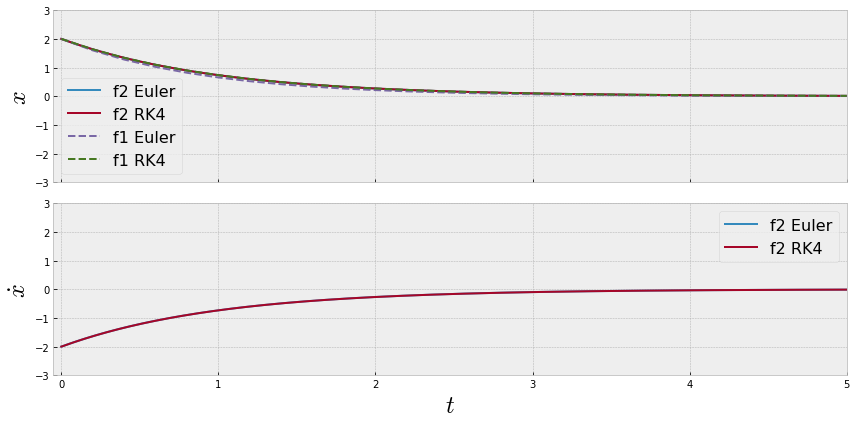

In [53]:
def v(x):
    return -x

def f1(x, t):
    return v(x)

def f2(X, t):
    # x[0] = x
    # x[1] = xdot
    alpha = 1e3
    dX = np.zeros(2)
    dX[0] = X[1]
    dX[1] = alpha*(v(X[0]) - X[1])
    return dX

# Common time variables
t0   = 0
Tmax = 5

# Initial conditions for f1
x01  = 2
# Timestep
h1    = 0.2
# Calculate trajectories
X1_euler, T1s = trajectory(x01, t0, Tmax, h1, f1, euler)
X1_rk4, T1s   = trajectory(x01, t0, Tmax, h1, f1, rk4)


# Initial conditions for f2, note that in this case
# we also need an initial value for the velocity
x02 = np.array([2, -2])
# Timestep
# Try also with h2 = 0.002009
h2 = 0.00200
# Calculate trajectories
X2_euler, T2s = trajectory(x02, t0, Tmax, h2, f2, euler)
X2_rk4, T2s   = trajectory(x02, t0, Tmax, h2, f2, rk4)

# Make a figure with two subplots
fig, ax = plt.subplots(nrows = 2, sharex = True, figsize = (12,6))

# Plot numerical solutions of position
ax[0].plot(T2s, X2_euler[:,0], label = 'f2 Euler')
ax[0].plot(T2s, X2_rk4[:,0], label = 'f2 RK4')

# Plot numerical solutions of position
ax[0].plot(T1s, X1_euler, '--', label = 'f1 Euler')
ax[0].plot(T1s, X1_rk4, '--', label = 'f1 RK4')

# Plot numerical solutions of velocity (f2 only)
ax[1].plot(T2s, X2_euler[:,1], label = 'f2 Euler')
ax[1].plot(T2s, X2_rk4[:,1], label = 'f2 RK4')

# Labels
ax[0].set_ylabel('$x$', fontsize = 24)
ax[1].set_ylabel('$\dot{x}$', fontsize = 24)
ax[1].set_xlabel('$t$', fontsize = 24)
# Add legend
ax[0].legend(fontsize = 16)
ax[1].legend(fontsize = 16)
# Plot limits
ax[0].set_ylim(-3, 3)
ax[1].set_ylim(-3, 3)
ax[1].set_xlim(-0.05, 5)
# Reduce whitespace
plt.tight_layout()

# Example 8 - Implicit solvers

For stiff equations, the best solution is often to use an implicit solver. In practice, the most common approach is to use a numerical library (see the scipy example below), but we illustrate the principle here, using the implicit Euler method.

Recall that the forward Euler method was

$$ x_{n+1} = x_n + h\cdot f(x_n, t_n).$$

The implicit Euler method (also known as backward Euler) is instead

$$ x_{n+1} = x_n + h\cdot f(x_{n+1}, t_{n+1}).$$

The problem then is of course that $x_{n+1}$ is unknown, and we have to solve an equation to find it. Methods of this kind are known as implicit methods, since $x_{n+1}$ is given implicitly, instead of explicitly. In general, some kind of numerical equation solver is used to find $x_{n+1}$.

In simple cases, such as the above example, we can solve the equation analytically. We have the second order ODE

$$\ddot{x} = \alpha (v(x) - \dot{x}).$$

We use the substitutions $x = x_1$, $\dot{x} = x_2$ to rewrite into a system of two first-order ODEs:

$$\dot{x_1} = x_2,$$
$$\dot{x_2} = \alpha \big(v(x_1) - x_2\big).$$

Inserting into the implicit Euler scheme, we find

$$ x_{1_{n+1}}  = x_{1_n} + h \cdot x_{2_{n+1}}, $$
$$ x_{2_{n+1}}  = x_{2_n} + h \cdot \alpha \big(v(x_{1_{n+1}}) - x_{2_{n+1}}\big).$$

This is a system of equations with two unknowns. Using that $v(x) = -x$, we can solve this system to find

$$ x_{1_{n+1}}  = x_{1_n} + h \cdot \frac{x_{2_n} - \alpha h x_{1_n}}{1 + \alpha h + \alpha h^2}, $$
$$ x_{2_{n+1}}  = \frac{x_{2_n} - \alpha h x_{1_n}}{1 + \alpha h + \alpha h^2}.$$


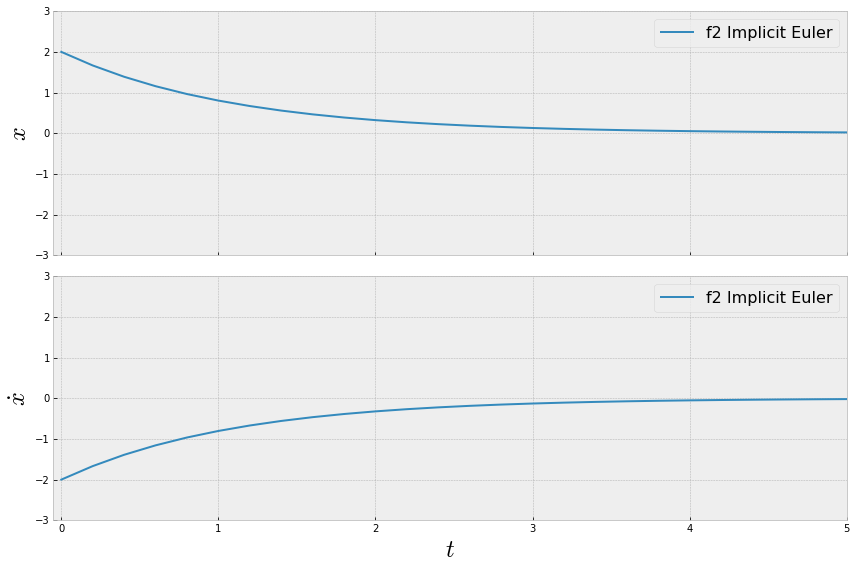

In [54]:
# Implementing the above equations in an implicit scheme
# Note that we are writing this method specifically for
# the problem we are looking at here. It does not work
# for other problems.

def implicit_euler(X, t, h, f):
    # The f isn't used for anything, but keeping
    # the call signature consistent allows us to
    # re-use the earlier trajectory function.
    alpha = 1e3
    x1 = X[0] + h*(X[1]-alpha*h*X[0]) / (1 + alpha*h + alpha*h**2)
    x2 = (X[1]-alpha*h*X[0]) / (1 + alpha*h + alpha*h**2)
    return np.array([x1, x2])


# Initial conditions for f2
x02 = np.array([2, -2])
# Timestep
# Note that the timestep can be orders of magnitude larger
# than what we found above for the explicit schemes.
h2 = 0.2
# Calculate trajectories
X2s, T2s = trajectory(x02, t0, Tmax, h2, f2, implicit_euler)

# Make a figure with two subplots
fig, ax = plt.subplots(nrows = 2, sharex = True, figsize = (12,8))

# Plot numerical solutions of position
ax[0].plot(T2s, X2s[:,0], label = 'f2 Implicit Euler')

# Plot numerical solutions of velocity
ax[1].plot(T2s, X2s[:,1], label = 'f2 Implicit Euler')

# Labels
ax[0].set_ylabel('$x$', fontsize = 24)
ax[1].set_ylabel('$\dot{x}$', fontsize = 24)
ax[1].set_xlabel('$t$', fontsize = 24)
# Add legend
ax[0].legend(fontsize = 16)
ax[1].legend(fontsize = 16)
# Plot limits
ax[0].set_ylim(-3, 3)
ax[1].set_ylim(-3, 3)
ax[1].set_xlim(-0.05, 5)
# Reduce whitespace
plt.tight_layout()

# Example 9 - Scipy.integrate.odeint
## (which is in practice a wrapper for lsoda)
### (which is written in fortran)

In practice, the best approach to numerical integration of ODEs is often to use code written by someone else. A useful example is `scipy.integrate.odeint`. This is a python wrapper to a fortran library called odepack, and specifically to the solver called lsoda. For more information, have a look at the scipy documentation:

https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.integrate.odeint.html

This particular solver uses dynamic timestep, and will automatically switch to an implicit solver if it detects a stiff equation.

Below, we try it out on the equation from case 2 above.

Things to try:
* Compare number of steps to the smallest number needed by Euler or 4th-order Runge-Kutta

Number of steps:  38
Average stepsize:  0.13157894736842105


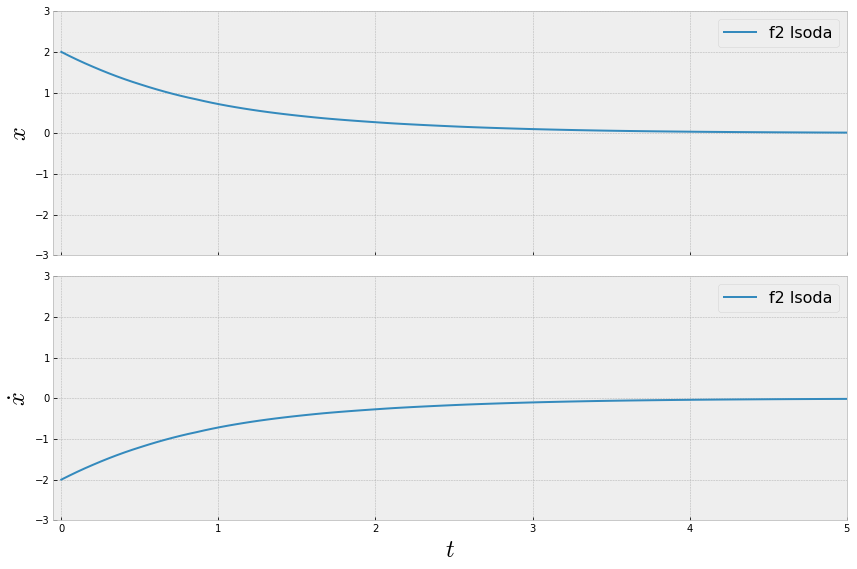

In [55]:
from scipy.integrate import odeint

def v(x):
    return -x

def f2(X, t):
    # x_1 = x
    # x_2 = xdot
    alpha = 1e3
    dX = np.zeros(2)
    dX[0] = X[1]
    dX[1] = alpha*(v(X[0]) - X[1])
    return dX

# Initial conditions for f2
x02  = np.array([2, -2])
t0   = 0
Tmax = 5
# Calculate trajectories
times = np.linspace(t0, Tmax, 100)
X2_lsoda, infodict = odeint(f2, x02, times, full_output = True, rtol = 1e-2, atol = 1e-2)

print('Number of steps: ', infodict['nst'][-1])
print('Average stepsize: ', Tmax / infodict['nst'][-1])

# Make a figure with two subplots
fig, ax = plt.subplots(nrows = 2, sharex = True, figsize = (12,8))

# Plot numerical solutions of position
ax[0].plot(times, X2_lsoda[:,0], label = 'f2 lsoda')

# Plot numerical solutions of velocity
ax[1].plot(times, X2_lsoda[:,1], label = 'f2 lsoda')

# Labels
ax[0].set_ylabel('$x$', fontsize = 24)
ax[1].set_ylabel('$\dot{x}$', fontsize = 24)
ax[1].set_xlabel('$t$', fontsize = 24)
# Add legend
ax[0].legend(fontsize = 16)
ax[1].legend(fontsize = 16)
# Plot limits
ax[0].set_ylim(-3, 3)
ax[1].set_ylim(-3, 3)
ax[1].set_xlim(-0.05, 5)
# Reduce whitespace
plt.tight_layout()